In [11]:
import numpy as np
from hilo_mpc import Model, NMPC, SimpleControlLoop, GPArray, Kernel, set_plot_backend, GP, ExponentialKernel, SquaredExponentialKernel
from matplotlib import pyplot as plt
import casadi as ca

In [12]:
# Setup Plant Model using Physical Equations (kinematic)

# Set plot backend
set_plot_backend('bokeh')

# Initialize empty model
plant = Model()

# Add equations
equations = """
dX/dt = v(k)*cos(theta(t))
dY/dt = v(k)*sin(theta(t))
dtheta/dt = w(k)
"""
plant.set_equations(equations=equations)

# Sampling time
dt = .01

# Discretize model
plant.discretize('erk', inplace=True)

# Set up model
plant.setup(dt=dt)

# Initial conditions
x0 = [1, 1, 0]
plant.set_initial_conditions(x0)

In [13]:
# Generate data
Tf = 30
N = int(Tf / dt)
time = np.linspace(0, Tf, N)

v = 2 + 0.1 * np.sin(time)
w = 0.5 + np.sin(time)

for i in range(N):
    plant.simulate(u=[v[i], w[i]])

# Plot results
plant.solution.plot()

# Generate features and labels
t_sim = plant.solution['t'].full()[:, ::50]
control = plant.solution['u'].full()[:, ::50]
states = plant.solution.get_by_id('x').full()[:, ::50]

features = np.vstack((states[:,:-1],control))
labels = states[:,1:]
print(features.shape)
print(labels.shape)
print(states.shape)
print(control.shape)
print(t_sim.shape)

(5, 60)
(3, 60)
(3, 61)
(2, 60)
(1, 61)


In [14]:
# Initialize GPs
sigma_n = 5e-3

kernel1 = SquaredExponentialKernel(active_dims=[1, 2, 3], ard=True)
kernel2 = SquaredExponentialKernel(active_dims=[1, 2, 3], ard=True)
kernel3 = SquaredExponentialKernel(active_dims=[1,2,3], ard=True)

    #PeriodicKernel(active_dims=[1,2,3], signal_variance=sigma_n, length_scales=1.0,                               period=10.0)

gp1 = GP(['x', 'y', 'theta', 'v', 'w'], ['x_hat'], kernel=kernel1, noise_variance=sigma_n ** 2)
gp1.noise_variance.fixed = True

gp2 = GP(['x', 'y', 'theta', 'v', 'w'], ['y_hat'], kernel=kernel2, noise_variance=sigma_n ** 2)
gp2.noise_variance.fixed = True

gp3 = GP(['x', 'y', 'theta', 'v', 'w'], ['theta_hat'], kernel=kernel3, noise_variance=sigma_n ** 2)
gp3.noise_variance.fixed = True

In [15]:
# Training of GP1
train_in =  features
train_out1 = labels[0,0:60].reshape((1,60))

gp1.set_training_data(train_in, train_out1)
gp1.setup()
gp1.fit_model()

# Training of GP2
train_in =  features
train_out2 = labels[1,0:60].reshape((1,60))

gp2.set_training_data(train_in, train_out2)
gp2.setup()
gp2.fit_model()

# Training of GP3
train_in =  features
train_out3 = labels[2,0:60].reshape((1,60))

gp3.set_training_data(train_in, train_out3)
gp3.setup()
gp3.fit_model()

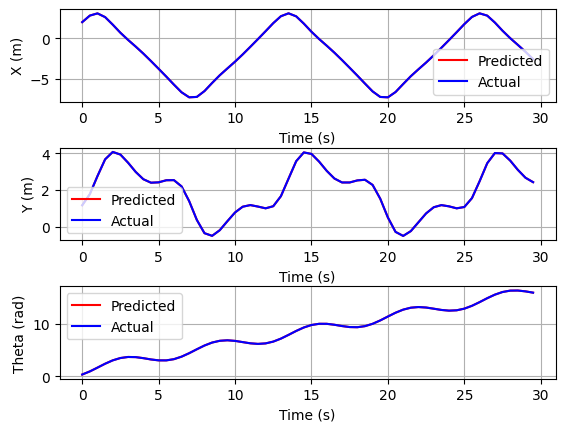

In [16]:
# Plots
gp_1_mean, _ = gp1.predict(train_in)
gp_2_mean, _ = gp2.predict(train_in)
gp_3_mean, _ = gp3.predict(train_in)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)

ax1.plot(t_sim[0,0:60],gp_1_mean[0,0:60], color="red", label = "Predicted")
ax1.plot(t_sim[0,0:60],states[0,1:61], color="blue", label = "Actual")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('X (m)')
ax1.legend()
ax1.grid(True)

ax2.plot(t_sim[0,0:60],gp_2_mean[0,0:60], color="red", label = "Predicted")
ax2.plot(t_sim[0,0:60],states[1,1:61], color="blue", label = "Actual")
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Y (m)')
ax2.legend()
ax2.grid(True)

ax3.plot(t_sim[0,0:60],gp_3_mean[0,0:60], color="red", label = "Predicted")
ax3.plot(t_sim[0,0:60],states[2,1:61], color="blue", label = "Actual")
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Theta (rad)')
ax3.legend()
ax3.grid(True)

In [17]:
#Create GP Prediction Model
gp_model = Model(plot_backend='bokeh', name='gp_model', discrete=True)

# Set states and inputs
s = gp_model.set_dynamical_states(['x','y','theta'])
u = gp_model.set_inputs(['v','w'])
# p = gp_model.set_parameters('c1', 'c2','c3')
# gp_model.set_measurement_equations([s[0], s[1], s[2]])
# c1 = p[0]
# c2 = p[1]
# c3 = p[2]
# x = c1*s[0]
# y = c2*s[1]
# theta = c3*s[2]
# v = u[0]
# w = u[1]

# x_next = gp1
# y_next = gp2
# theta_next = gp3
# gp_model.set_dynamical_equations(['x_next', 'y_next', 'theta_next'])
gp_model.set_dynamical_equations(['0', '0', '0'])
gp_model += [gp1, gp2, gp3]

# Set up the model
gp_model.setup(dt=0.01)

#p0 = [1,1,1]
# Set initial conditions
x0_GP = [1, 1, 0]
gp_model.set_initial_conditions(x0=x0_GP)
#gp_model.set_initial_parameter_values(p0)

C:\Users\ssathe\PycharmProjects\GP_NMPC\venv\lib\site-packages\hilo_mpc\modules\dynamic_model\dynamic_model.py:2939: UserWarning: The model was initialized as a discrete model, but no sampling time was implemented in the model. Assuming that the sampling time 'dt' is already integrated numerically.
  warnings.warn("The model was initialized as a discrete model, but no sampling time was implemented in "


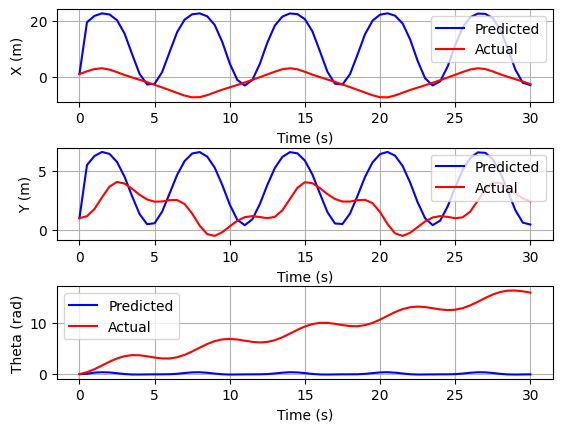

In [18]:
#Simulate GP Model
Tf = 30
N = int(Tf / dt)
time = np.linspace(0, Tf, N)

v = 2 + 0.1 * np.sin(time)
w = 0.5 + np.sin(time)

# Initial conditions
x0 = [1, 1, 0]
plant.set_initial_conditions(x0)
gp_model.set_initial_conditions(x0)

for i in range(N):
    gp_model.simulate(u=[v[i], w[i]])
    plant.simulate(u=[v[i], w[i]])

# Plot results
gp_model.solution.plot()

# Generate features and labels
t_sim_hat = gp_model.solution['t'].full()[:, ::50]
control_hat = gp_model.solution['u'].full()[:, ::50]
states_hat = gp_model.solution.get_by_id('x').full()[:, ::50]

t_sim = plant.solution['t'].full()[:, ::50]
control = plant.solution['u'].full()[:, ::50]
states = plant.solution.get_by_id('x').full()[:, ::50]

# Plot Training Data
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)

ax1.plot(t_sim_hat[0,:], states_hat[0,:], color = "blue", label = "Predicted")
ax1.plot(t_sim[0,:], states[0,:], color = "red", label = "Actual")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('X (m)')
ax1.legend()
ax1.grid(True)

ax2.plot(t_sim_hat[0,:], states_hat[1,:], color = "blue", label = "Predicted")
ax2.plot(t_sim[0,:3000], states[1,:3000], color = "red", label = "Actual")
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Y (m)')
ax2.legend()
ax2.grid(True)

ax3.plot(t_sim_hat[0,:3000], states_hat[2,:3000], color = "blue", label = "Predicted")
ax3.plot(t_sim[0,:3000], states[2,:3000], color = "red", label = "Actual")
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Theta (rad)')
ax3.legend()
ax3.grid(True)

In [19]:
print(states_hat)

[[ 1.00000000e+00  1.95784686e+01  2.18506676e+01  2.27681968e+01
   2.23683083e+01  2.03051169e+01  1.55593228e+01  8.18027965e+00
   1.08674002e+00 -2.70686892e+00 -2.50036950e+00  1.69532206e+00
   8.91663997e+00  1.60533282e+01  2.05305466e+01  2.24375199e+01
   2.27508021e+01  2.17256868e+01  1.86097301e+01  1.25433951e+01
   4.80722346e+00 -1.06129814e+00 -3.10918796e+00 -1.14351473e+00
   4.62739048e+00  1.22648005e+01  1.83855791e+01  2.16190447e+01
   2.27306799e+01  2.24915155e+01  2.06867338e+01  1.63194721e+01
   9.16421164e+00  1.82594747e+00 -2.45246886e+00 -2.74457295e+00
   9.68012791e-01  7.94638526e+00  1.52854997e+01  2.01338448e+01
   2.23037059e+01  2.27793474e+01  2.19442345e+01  1.91498262e+01
   1.34481538e+01  5.73891202e+00 -5.26256315e-01 -3.07284000e+00
  -1.60741356e+00  3.74306245e+00  1.13352875e+01  1.77832538e+01
   2.13552455e+01  2.26736952e+01  2.25917067e+01  2.10280734e+01
   1.70318684e+01  1.01442088e+01  2.61673119e+00 -2.13578886e+00
  -2.92638